# Udacity Machine Learning Nanodegree Capstone Project


## Applying Machine Learning Algorithms to Building a Stock Trading Strategy Based on Demand Zones


In this project, I’ll research applicability of Machine Learning methods to intraday stock market trading. Specifically, I’ll focus on evaluating so-called “Demand Zones” in terms of potential profitability. The task is to identify "buy" oppotunities with high probability of short-term growth based on analysis of market situations.  

Structure of the notebook:

 - Exploring the Data
 - Data preprocessing/cleaning
 - Evaluate Algorithms
 - Model Tuning to Improve Result
 - Final conclusion
 
 ML algorithms considered:
 


In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors 
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation,LSTM
from keras.callbacks import ModelCheckpoint 
from keras.utils.generic_utils import get_custom_objects

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('data.csv')

# Printing out the first 10 rows of our data
data[:10]

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


growth  coefGT  sma_dif  dif_high   dif_low  dif_open  zone_interval  \
0    0.61  4.6142  0.32087  1.184069  0.287873 -1.170213             22   
1    0.76  4.0904  0.15958  2.077432  0.665399 -0.094340             30   
2    1.04  3.2818  0.54613  1.292850  4.460814 -0.738868             52   
3    1.33  1.3255  0.43241  2.700049  3.348554  2.361809            167   
4    2.16  2.0244  0.39228  2.156567  1.990542  1.990542            177   
5    0.63  0.9333  0.35884  1.502865  0.729689 -0.505594            112   
6    1.04  1.2079  0.50751  1.065891  2.457185  2.051916            143   
7    0.57  0.4425  0.18057  0.664207  0.221893 -0.586941            214   
8    0.71  3.8798  0.27324  1.061650  4.010074  4.010074             30   
9    1.36  2.7353  0.47207  1.358278  0.179718 -0.535305             82   

   dif_prev_close  dif_bid_ask  zone_size    ...      correlSP  sp_open_dif  \
0        0.248845     0.035894   0.107759    ...      0.391960    -0.118873   
1        1.145038     0.094518   0.189394    ...      0.690680    -0.324616   
2       -3.108515     0.019592   0.137444    ...     -0.200070    -0.018288   
3        0.403633     0.049116   0.073783    ...      0.083169    -0.013716   
4        0.198347     0.032359   0.043211    ...      0.063600    -0.027432   
5        0.627842     0.043267   0.027075    ...      0.631430    -0.057151   
6       -0.049419     0.024231   0.072833    ...      0.659537     0.000000   
7       -0.243962     0.024606   0.000000    ...      0.596823     0.000000   
8        0.938600     0.037265   0.186846    ...      0.716578     0.127947   
9        0.770614     0.025634   0.038506    ...      0.684426    -0.095961   

   sp_dif_high  sp_dif_low  winloss    ask  symbol       alertTime  \
0     0.151057    0.045796       -1  27.87  FOSL    9/6/2016 10:00   
1     0.357782    0.068852        1  10.59  FCX     9/6/2016 10:57   
2     0.050302    0.376389       -1  51.05  HES     9/6/2016 12:02   
3     0.082308    0.380979        1  20.37  ENDP    9/6/2016 13:20   
4     0.096040    0.367208       -1  92.74  PRGO    9/6/2016 13:29   
5     0.125803    0.337373        0  92.49  WYNN    9/6/2016 13:36   
6     0.068581    0.394749        1  41.28  RRC     9/6/2016 14:43   
7     0.068581    0.394749        0  40.65  HIG     9/6/2016 14:43   
8     0.045637    0.196625        1  53.69  UAL     9/7/2016 10:33   
9     0.269862    0.022875        1  39.02  UA      9/7/2016 11:19   

         sellTime  sellPrice  
0  9/6/2016 10:18    27.6900  
1  9/6/2016 11:27    10.6700  
2  9/6/2016 12:18    50.7000  
3  9/6/2016 15:53    20.4800  
4  9/6/2016 15:07    92.2401  
5  9/6/2016 15:59    92.6900  
6  9/6/2016 15:51    41.5200  
7  9/6/2016 15:59    40.7100  
8  9/7/2016 10:38    53.9700  
9  9/7/2016 12:44    39.2200  

[10 rows x 24 columns]

## Data description

Definitions:
 - T1 - time when the Demand zone was initially detected.
 - T2 - time of the price peak after the zone 
 - T3 - time when the price came back to the demand zone
 
Fields desriptions:
 - *growth*: percentage of a price change between times T1 and T2. 
 - *coefGT* – ratio between growth and time interval (in minutes) between T1 and T3. It is calculated as:
 - *sma_dif* – difference between price at time T3 and simple moving average (SMA) price for last 30 minutes.
    
    
    coefGT=10000*growth/(T3-T1)
	
 - *dif_high* – percent difference between current day high and current price (%)
 - *dif_low* – percent difference between current day low and current price (%)
 - *dif_open* – price difference with current day open (%)
 - *zone_interval* – number of minutes between T1 and T3 
 - *dif_prev_close* - price difference with previous day close (%)
 - *dif_bid_ask* – difference between bid and ask at time T3 (%)
 - *zone_size* - price difference between top and bottom of the zone (%)
 - *rsi* – Relative Strength Index 
 - *macd* - Moving average convergence divergence 
 - *volatility* -  intraday volatility calculated as standard deviation of closing prices for each minute.
 - *correlSP* – correlation of current stock with S&P 500 index
 - *SP_SMA_dif* – difference of current S&P 500 index value and 50-minute simple moving average (%)
 -	*sp_open_dif* –  difference between SPY price at day open and price at T3 (%)
 -	*sp_dif_high* – difference SPY’s day high and price at T3 (%)
 -	*sp_dif_low* – difference SPY’s day low and price at T3 (%)
 -	*winloss* – 1 if the stock sold with profit, -1 if the stock sold with loss, 0 if the price did not achieve the target or stop-loss (in this case, it is sold in the end of the trading day).  
 -	*ask* – Ask price at T3 moment. Considered as a hypothetical “buy” price. 
 -	*symbol* – stock symbol
 -	*alertTime* – T3 time 
 -	*sellTime* – time when a hypothetical trade was closed (stock sold)
 

## Cleaning the data

Removing the fields not relevant for analysis.

In [2]:
vars1=["growth", "coefGT", "sma_dif", "dif_high", "dif_low", "dif_open", "zone_interval", "dif_prev_close", "dif_bid_ask", "zone_size", "RSI", "MACD", "volatility", "SP_MA_dif", "correlSP", "sp_open_dif", "sp_dif_high", "sp_dif_low"]


data = data.dropna()
data = data.loc[data['winloss'] != 0] # at this point, we'll consider only stocks that were sold
data.drop(['sellPrice'],axis = 1, inplace = True)
data.drop(['ask'],axis = 1, inplace = True)
data.drop(['alertTime'],axis = 1, inplace = True)
data.drop(['sellTime'],axis = 1, inplace = True)
data.drop(['symbol'],axis = 1, inplace = True)

# Printing out the first 10 rows of our data
data[:10]
from IPython.display import display
display(data.describe())

growth       coefGT      sma_dif     dif_high      dif_low  \
count  5815.000000  5815.000000  5815.000000  5815.000000  5815.000000   
mean      0.841426     3.206730     0.318094     1.539568     1.230447   
std       0.350353     2.502935     0.282624     1.262111     1.283467   
min       0.500000     0.321300    -2.456700     0.401606     0.028694   
25%       0.590000     1.488050     0.185475     0.757093     0.353497   
50%       0.730000     2.469500     0.307210     1.129032     0.799201   
75%       0.970000     4.107550     0.447150     1.850245     1.629718   
max       2.460000    35.318300     2.370560    16.760882    14.199134   

          dif_open  zone_interval  dif_prev_close  dif_bid_ask    zone_size  \
count  5815.000000    5815.000000     5815.000000  5815.000000  5815.000000   
mean     -0.043999      69.724678        0.003208     0.057290     0.094512   
std       1.867581      55.131578        1.811584     0.038948     0.065693   
min     -13.812424       6.000000      -23.375262     0.000000     0.000000   
25%      -0.956099      29.000000       -0.461889     0.029645     0.045956   
50%       0.000000      52.000000        0.021515     0.047214     0.082169   
75%       0.889628      93.000000        0.506652     0.074294     0.131678   
max      13.267497     311.000000       20.839046     0.381106     0.396040   

               RSI         MACD   volatility    SP_MA_dif     correlSP  \
count  5815.000000  5815.000000  5815.000000  5815.000000  5815.000000   
mean     37.843152    -0.026715     0.127141    -0.045965     0.302850   
std       8.048408     0.144294     0.166488     0.111237     0.453883   
min       8.215772    -1.534527     0.004000    -1.003846    -0.916082   
25%      32.825300    -0.065563     0.040000    -0.092844    -0.025938   
50%      37.765116    -0.020056     0.076000    -0.024595     0.393974   
75%      42.743816     0.014092     0.145000     0.017709     0.683222   
max      83.365048     1.790869     2.462000     0.436704     0.986407   

       sp_open_dif  sp_dif_high   sp_dif_low      winloss  
count  5815.000000  5815.000000  5815.000000  5815.000000  
mean     -0.026717     0.355461     0.304628    -0.040757  
std       0.508135     0.411360     0.356390     0.999255  
min      -2.847398     0.000000     0.000000    -1.000000  
25%      -0.228159     0.096504     0.090866    -1.000000  
50%      -0.011718     0.221995     0.203813    -1.000000  
75%       0.179269     0.437614     0.378978     1.000000  
max       2.533400     3.226697     2.941631     1.000000

## Plotting the data

Let's take a look at the following charts:
 - feature's data distributions
 - correlation matrix (heatmap)
 - correlation charts


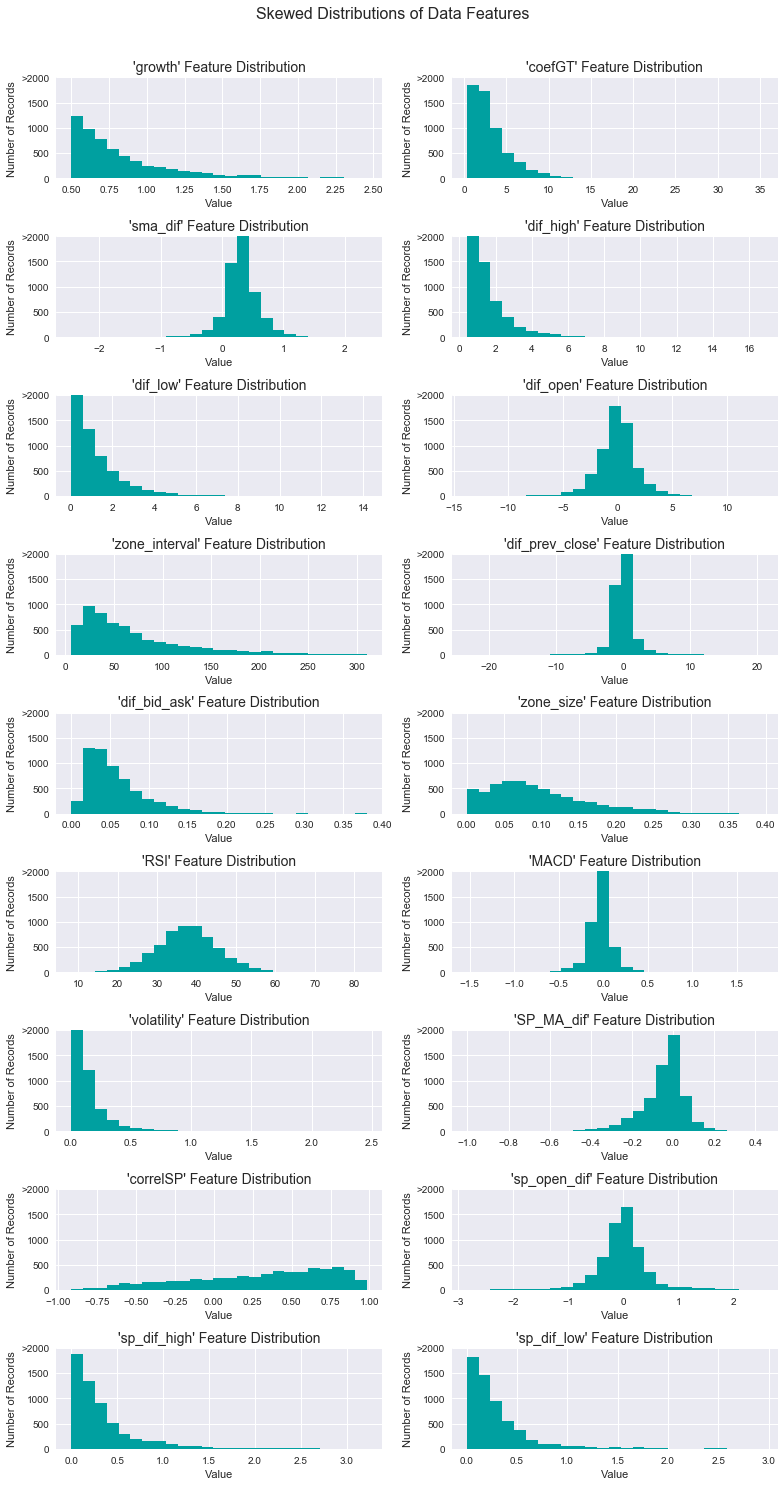

In [3]:
import visuals as vs


vs.distribution(data, transformed = False)

def plotHeatmap(data):

    fig, ax = plt.subplots(figsize=(13,13))         # Sample figsize in inches
    sns.set(font_scale=1.4) 
    sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax,annot_kws={"size": 12})

def plotScatter(data):

     #SCATTER PLOT MATRIX
    sns.set(font_scale=3)
    sns.set(style="ticks", color_codes=True)
    g=sns.pairplot(data, kind="scatter", hue="winloss", vars = vars1, plot_kws=dict(s=5, edgecolor="white", linewidth=.05),palette = {1:'blue',-1:'red'})
    g.fig.set_size_inches(25,25)
    xlabels,ylabels = [],[]

    for ax in g.axes[-1,:]:
        xlabel = ax.xaxis.get_label_text()
        xlabels.append(xlabel)
    for ax in g.axes[:,0]:
        ylabel = ax.yaxis.get_label_text()
        ylabels.append(ylabel)

    for i in range(len(xlabels)):
        for j in range(len(ylabels)):
            g.axes[j,i].xaxis.set_label_text(xlabels[i])
            g.axes[j,i].yaxis.set_label_text(ylabels[j])

    for ax in g.axes.flat:
        _ = plt.setp(ax.get_yticklabels(), visible=True)
        _ = plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()

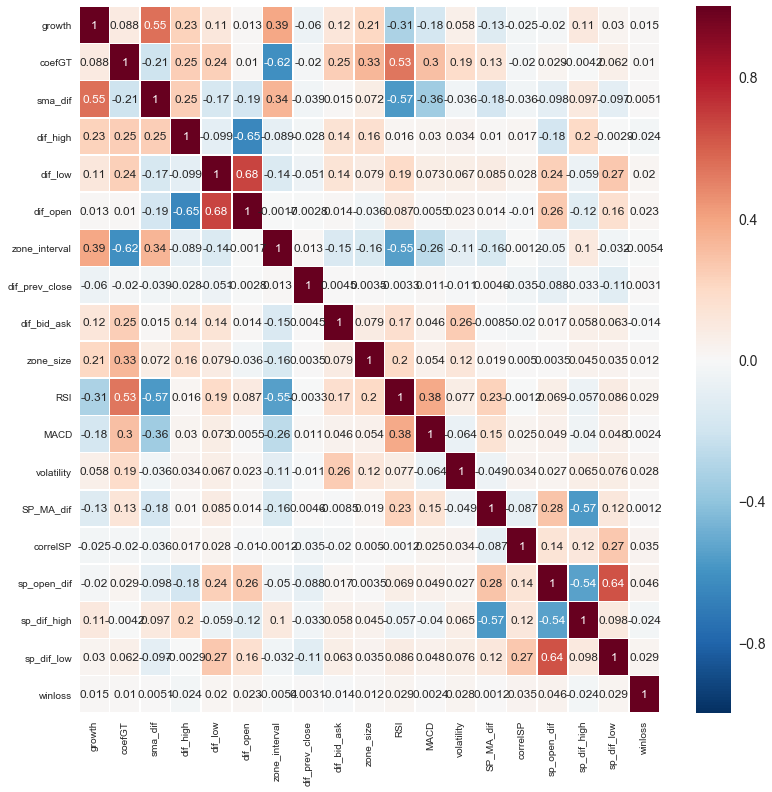

In [4]:
plotHeatmap(data)

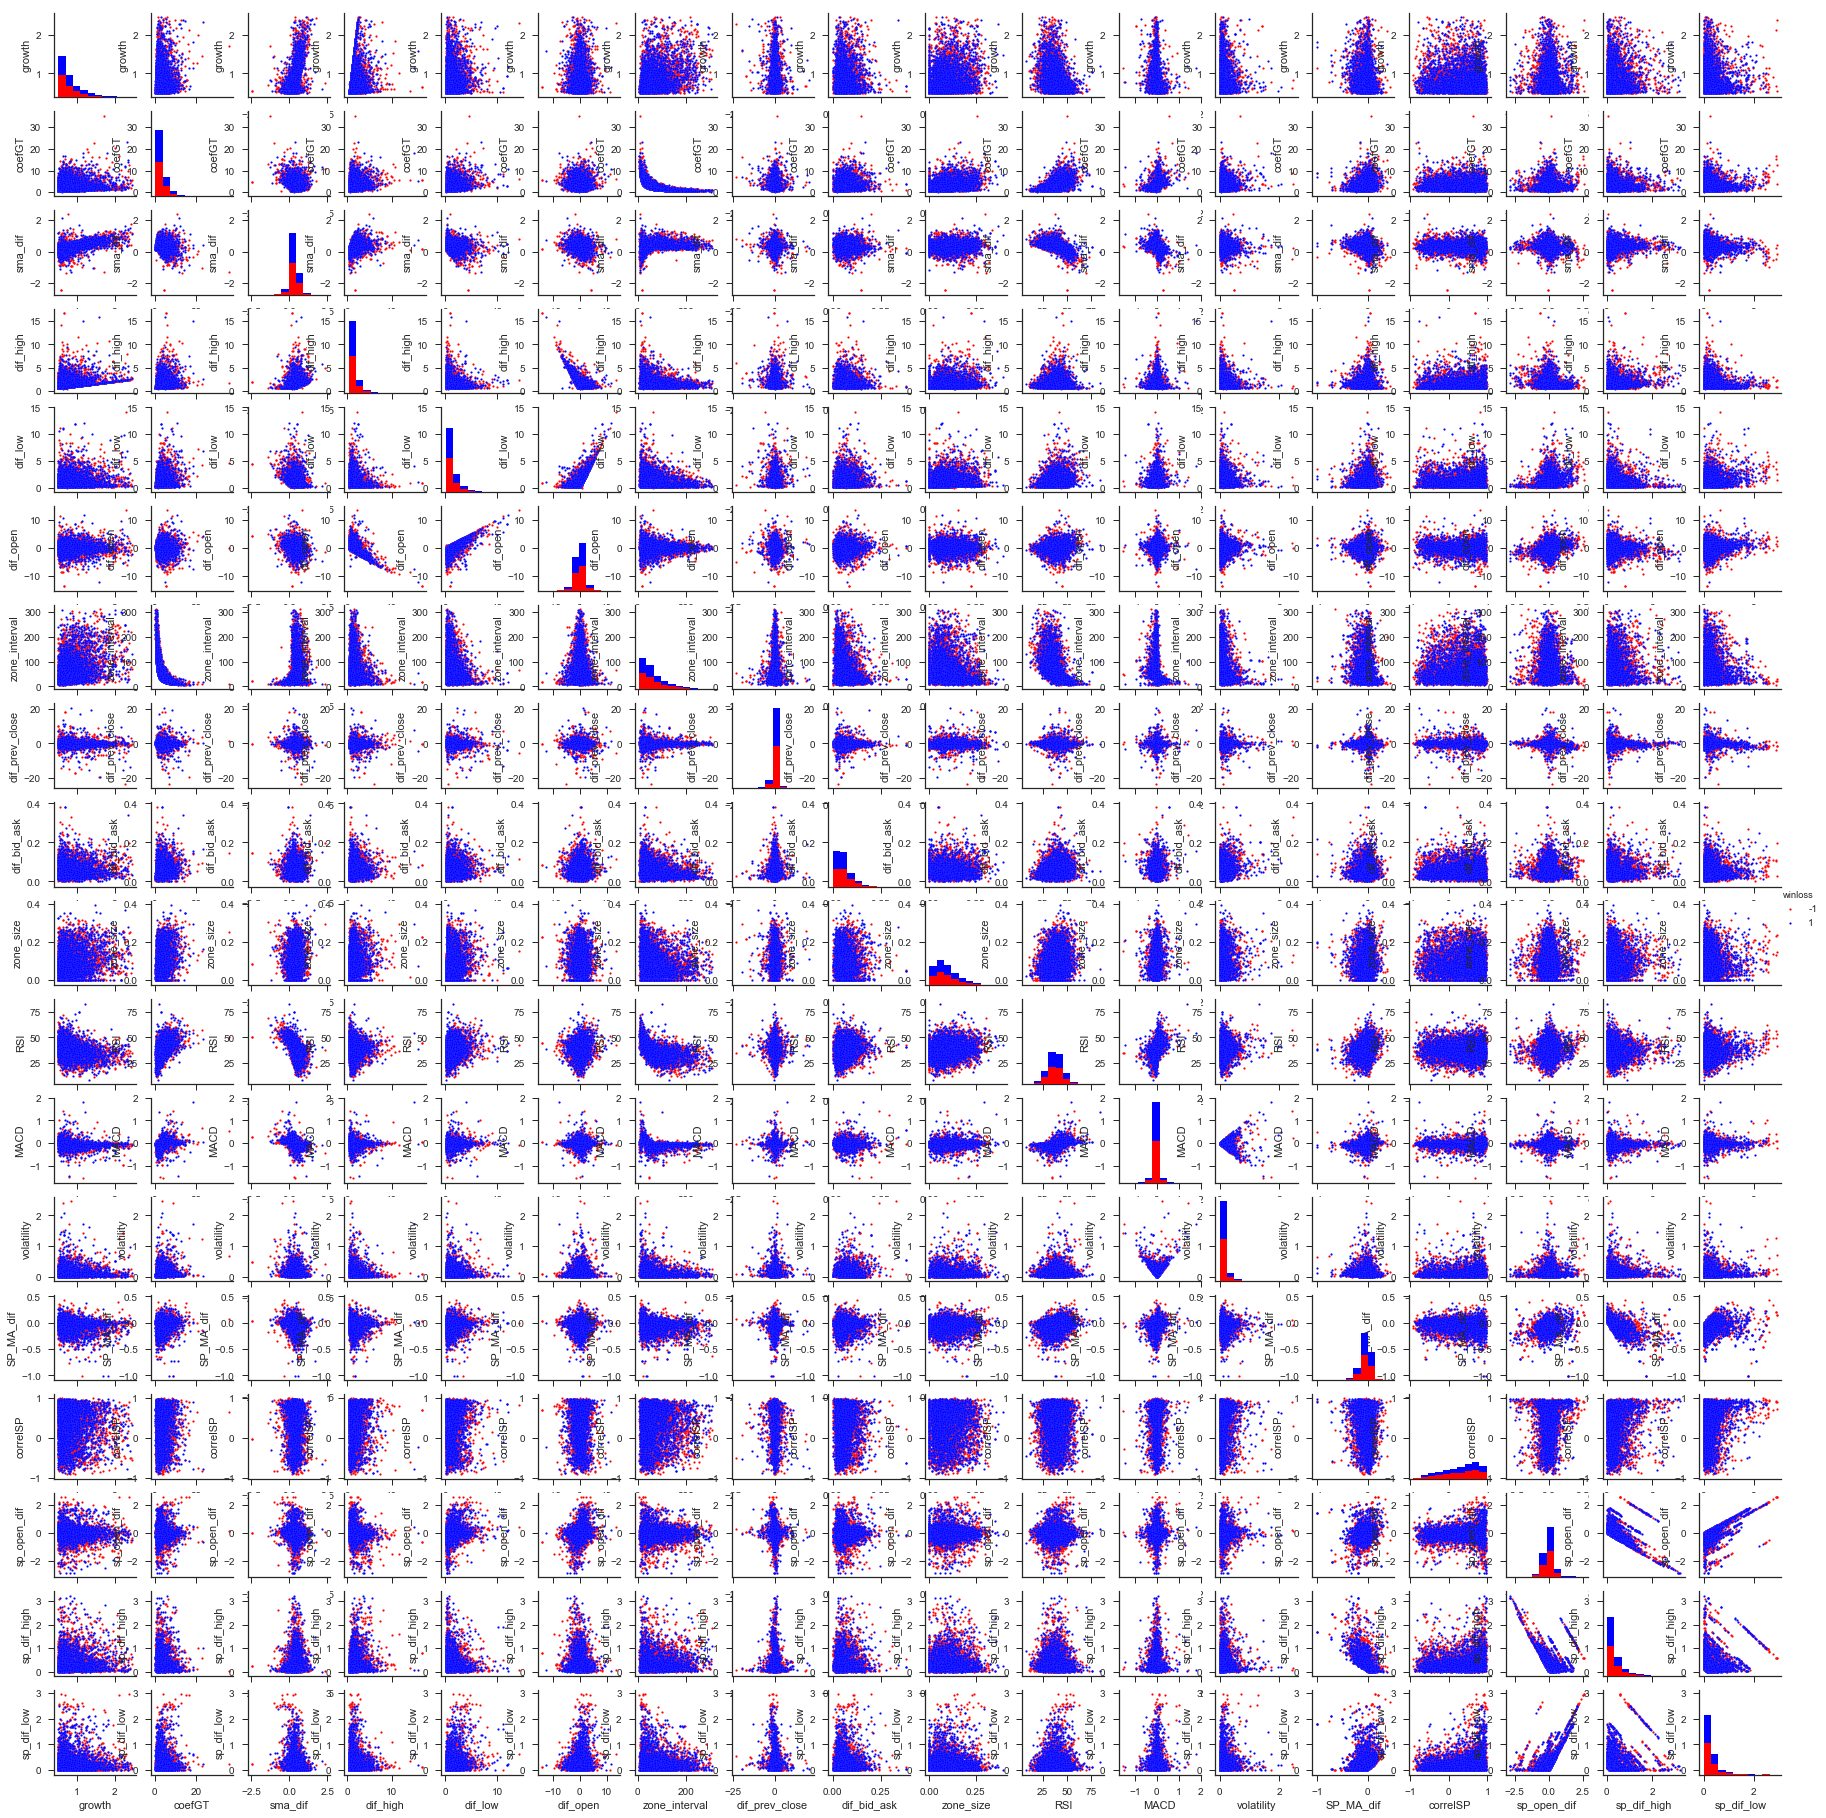

In [5]:
plotScatter(data)

The scatter plot is hard to read. You can see the polts in higher resolution in the 'plots' folder of this repository.


## Data Preprocessing 


Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured. The original dataset contains outliers. Also, there are several features whose values tend to lie near a single number. In addition, value ranges of some features are significantly different from each other (data is not normalized).  Machine Learning algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. Once transformation is applied, observing the data in its raw form will no longer have the same original meaning.

For highly-skewed feature distributions ('growth', 'coefGT', ‘dif_high’, ‘dif_low’, ‘zone_interval’, ‘dif_bid_ask’, ‘zone_size’, ‘volatility’, ‘correlSP’) it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a machine learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Since the logarithm of 0 is undefined, we must translate the values by a small amount above 0 to apply the logarithm successfully.

In addition to performing transformations on features that are highly skewed, it is a good practice to perform some type of scaling. Applying a scaling to the data does not change the shape of each feature's distribution. However, normalization ensures that each feature is treated equally when applying the learning algorithm. I used the MinMaxScaler method from sklearn.preprocessing package. 


In [4]:
# initialize the list of skewed features
skewed = ["sma_dif", "growth", "coefGT", "dif_high", "dif_low", "zone_interval", "dif_bid_ask", "zone_size", "volatility", "correlSP","sp_open_dif", "sp_dif_high", "sp_dif_low"]

features_raw = data.dropna()

# applying logarithmic transformation
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))
features_log_transformed = features_log_transformed.dropna()

# NORMALIZATION 
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler and apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = vars1

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

data = features_log_minmax_transform


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Transformed data description and visualization:

In [7]:
display(data.describe())

growth       coefGT      sma_dif     dif_high      dif_low  \
count  5815.000000  5815.000000  5815.000000  5815.000000  5815.000000   
mean      0.841426     3.206730     0.318094     1.539568     1.230447   
std       0.350353     2.502935     0.282624     1.262111     1.283467   
min       0.500000     0.321300    -2.456700     0.401606     0.028694   
25%       0.590000     1.488050     0.185475     0.757093     0.353497   
50%       0.730000     2.469500     0.307210     1.129032     0.799201   
75%       0.970000     4.107550     0.447150     1.850245     1.629718   
max       2.460000    35.318300     2.370560    16.760882    14.199134   

          dif_open  zone_interval  dif_prev_close  dif_bid_ask    zone_size  \
count  5815.000000    5815.000000     5815.000000  5815.000000  5815.000000   
mean     -0.043999      69.724678        0.003208     0.057290     0.094512   
std       1.867581      55.131578        1.811584     0.038948     0.065693   
min     -13.812424       6.000000      -23.375262     0.000000     0.000000   
25%      -0.956099      29.000000       -0.461889     0.029645     0.045956   
50%       0.000000      52.000000        0.021515     0.047214     0.082169   
75%       0.889628      93.000000        0.506652     0.074294     0.131678   
max      13.267497     311.000000       20.839046     0.381106     0.396040   

               RSI         MACD   volatility    SP_MA_dif     correlSP  \
count  5815.000000  5815.000000  5815.000000  5815.000000  5815.000000   
mean     37.843152    -0.026715     0.127141    -0.045965     0.302850   
std       8.048408     0.144294     0.166488     0.111237     0.453883   
min       8.215772    -1.534527     0.004000    -1.003846    -0.916082   
25%      32.825300    -0.065563     0.040000    -0.092844    -0.025938   
50%      37.765116    -0.020056     0.076000    -0.024595     0.393974   
75%      42.743816     0.014092     0.145000     0.017709     0.683222   
max      83.365048     1.790869     2.462000     0.436704     0.986407   

       sp_open_dif  sp_dif_high   sp_dif_low      winloss  
count  5815.000000  5815.000000  5815.000000  5815.000000  
mean     -0.026717     0.355461     0.304628    -0.040757  
std       0.508135     0.411360     0.356390     0.999255  
min      -2.847398     0.000000     0.000000    -1.000000  
25%      -0.228159     0.096504     0.090866    -1.000000  
50%      -0.011718     0.221995     0.203813    -1.000000  
75%       0.179269     0.437614     0.378978     1.000000  
max       2.533400     3.226697     2.941631     1.000000

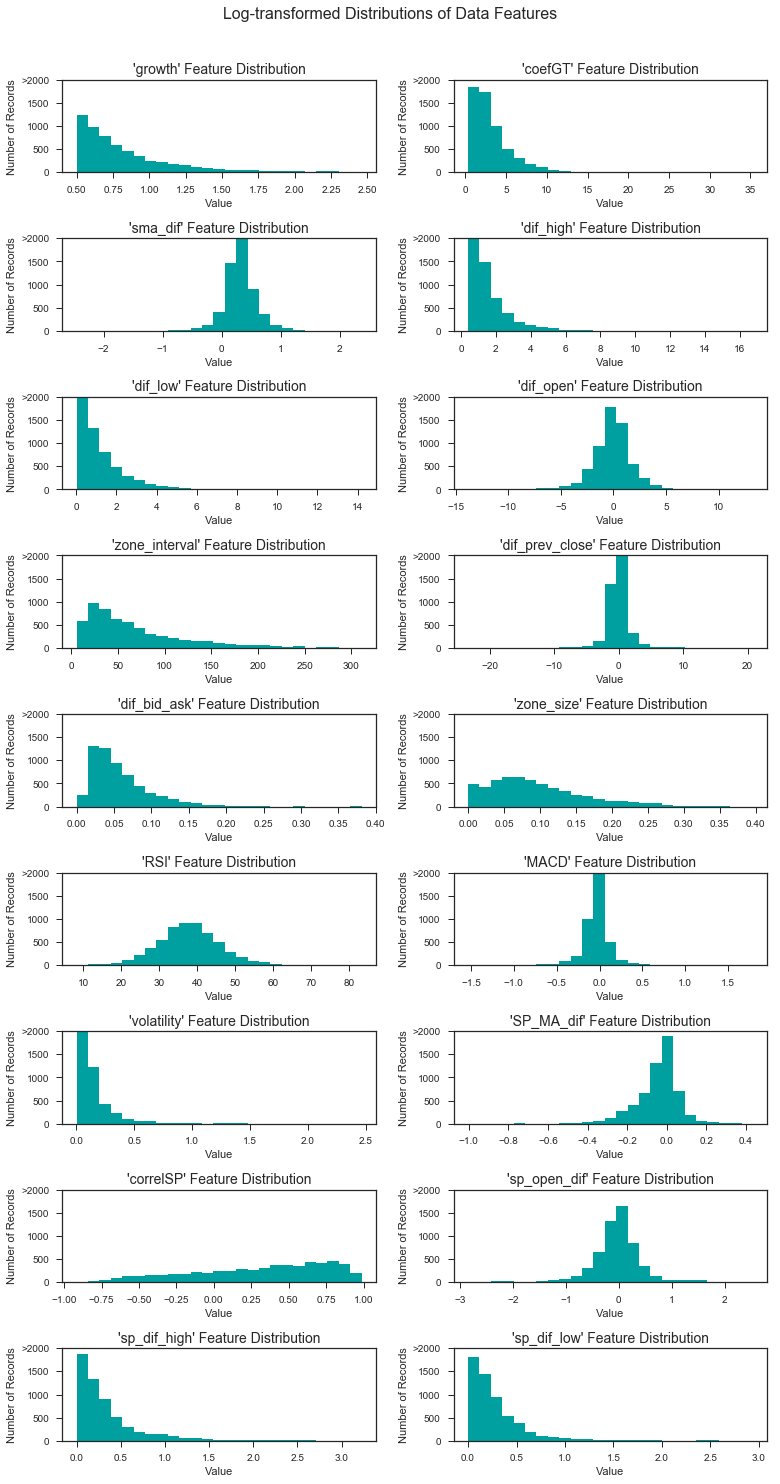

In [8]:
vs.distribution(data, transformed = True)

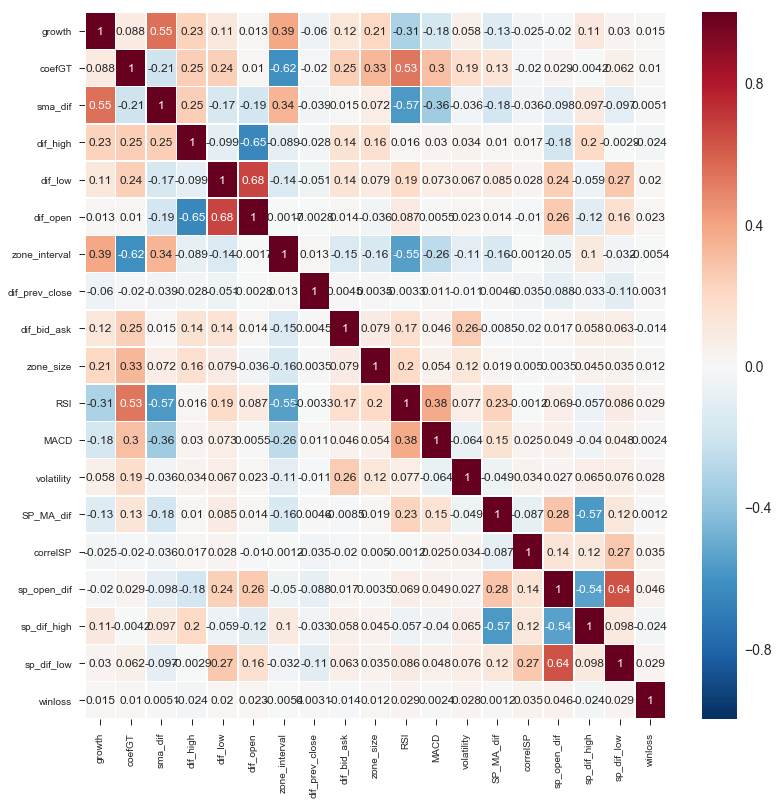

In [9]:
plotHeatmap(data)

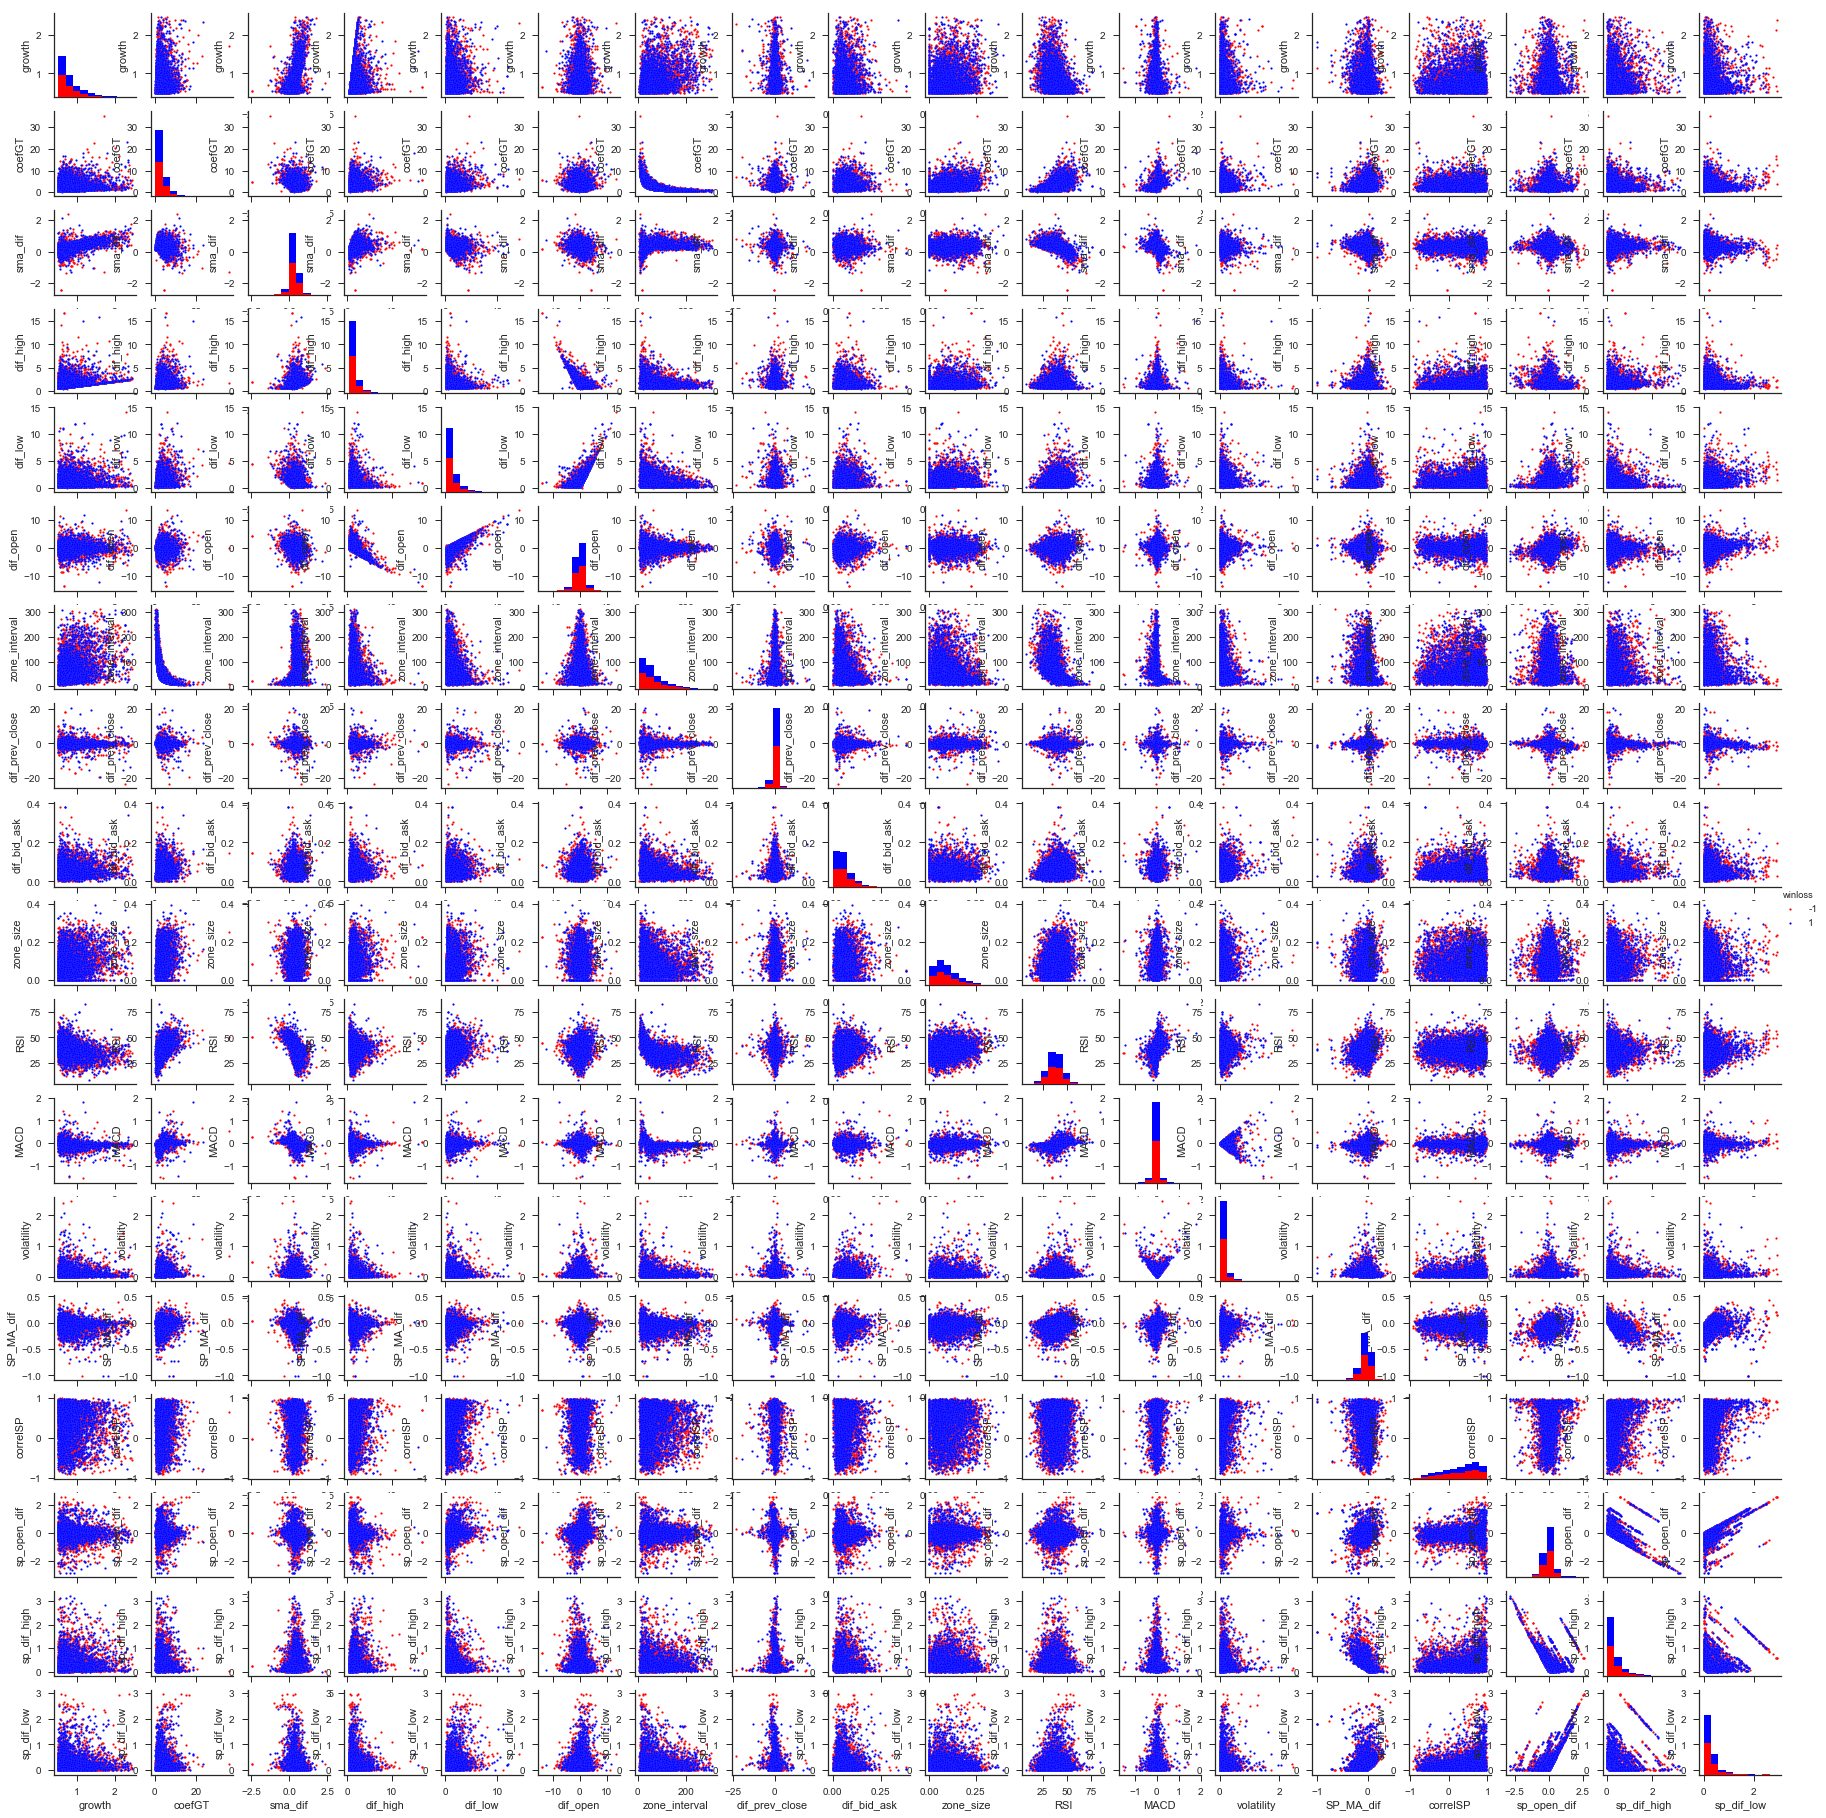

In [10]:
plotScatter(data)

## Splitting the data 

In order to test the algorithms, we'll split the data into a Training and a Testing set. The size of the testing set will be 20% of the total data. Also, we'll split the data into features (X) and targets (y).

In [5]:
outcomes = data['winloss']
features = data.drop('winloss', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

print("Number of training samples is", len(X_train))
print("Number of testing samples is", len(X_test))
print(X_train[:10])
print(X_test[:10])

Number of training samples is 4492
Number of testing samples is 1124
        growth    coefGT   sma_dif  dif_high   dif_low  dif_open  \
6362  0.211474  0.307985  0.752210  0.303754  0.147268  0.436546   
1948  0.015847  0.473846  0.685875  0.032186  0.210943  0.531960   
3376  0.128449  0.298445  0.713984  0.078912  0.082857  0.497822   
760   0.142693  0.470585  0.675982  0.078167  0.545280  0.635506   
2639  0.000000  0.330605  0.686211  0.031799  0.145514  0.518840   
3800  0.046926  0.290857  0.736339  0.419266  0.027458  0.404003   
6003  0.289109  0.478787  0.757590  0.401617  0.002825  0.470024   
4580  0.015847  0.628318  0.571089  0.230488  0.397046  0.534853   
1037  0.121264  0.340180  0.756180  0.117474  0.073716  0.497911   
507   0.218139  0.593770  0.685772  0.099147  0.318452  0.527937   

      zone_interval  dif_prev_close  dif_bid_ask  zone_size       RSI  \
6362       0.568228        0.545481     0.224810   0.445748  0.342809   
1948       0.290566        0.533996 

## Applying K-Nearest Neighbor Algorithm

The first algorithm I will consider is K-Nearest Neighbors.  In this algorithm, a data point is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. K – number of neighbors – is the only hyperparameter of the algorithm. Obviously, this algorithm is very sensitive to the local structure of the dataset.


In [7]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    
    return score

def fit_redict_print(model):
    model.fit(X_train, y_train)

    ## Making predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    score = r2_score(y_test, y_test_pred)

    print('Training accuracy:', round(train_accuracy,3))
    print('Test accuracy:', round(test_accuracy,3))

    print('R2 score:', round(score,3))
    print("Classification Report: \n",classification_report(y_test, y_test_pred))

    
#  running the grid search to find the optimal number of neighbors
param_test1 = {
    'n_neighbors': range(2,100)
}

estimator = KNeighborsClassifier()
gs = GridSearchCV(estimator = estimator, param_grid = param_test1, scoring = 'accuracy', n_jobs = 4, iid = False, cv = 5)
gs.fit(X_train,y_train)

#print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)


Best params:  {'n_neighbors': 2}
Best score:  0.5287193803000129


In [8]:
# applying the optimal number of neghbors
KNNModel = KNeighborsClassifier(n_neighbors=5)
fit_redict_print(KNNModel)   


Training accuracy: 0.703
Test accuracy: 0.518
R2 score: -0.93
Classification Report: 
              precision    recall  f1-score   support

         -1       0.53      0.55      0.54       573
          1       0.51      0.49      0.50       551

avg / total       0.52      0.52      0.52      1124



## Applying Decision Trees


Decision tree learning is a method commonly used in data science. The goal is to create a model that predicts the value of a target variable based on several input variables. Each interior node corresponds to one of the input variables (features); there are edges to children for each of the possible values of that input variable. Each leaf represents a value of the target variable given the values of the input variables represented by the path from the root to the leaf.


In [55]:
# tuning the decision tree

params = {
    'max_depth': range(10,200,10),
    'min_samples_leaf': range(10,200,20),
    'min_samples_split': range(10,200,20),
    'max_features': range(3,18)
    
}

estimator = DecisionTreeClassifier()
gs = GridSearchCV(estimator = estimator, param_grid = params, scoring = 'accuracy', n_jobs = 4, iid = False, cv = 5)
gs.fit(X_train,y_train)

#print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)


Best params:  {'max_depth': 140, 'max_features': 12, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best score:  0.546303887189411


In [58]:
DecTreeModel = DecisionTreeClassifier(max_depth=140, min_samples_leaf=10, min_samples_split=10,max_features = 12)
fit_redict_print(DecTreeModel)  

Training accuracy: 0.793
Test accuracy: 0.522
R2 score: -0.912
Classification Report: 
              precision    recall  f1-score   support

         -1       0.53      0.54      0.54       573
          1       0.51      0.50      0.51       551

avg / total       0.52      0.52      0.52      1124



## Applying Support Vector Machines 

In the scope of this research, I used the SVM algorithm with polynomial kernel of variable degree as well as RBF kernel with variable gamma-parameter. 


In [65]:
params = {
    'degree': range(2,9)
}

estimator = SVC(kernel='poly')
gs = GridSearchCV(estimator = estimator, param_grid = params, scoring = 'accuracy', n_jobs = 4, iid = False, cv = 5)
gs.fit(X_train,y_train)

#print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)

Best params:  {'degree': 5}
Best score:  0.5182546399709892


In [62]:
# Polynomial kernel
SVM_poly_Model = SVC(kernel='poly',degree=5)

fit_redict_print(SVM_poly_Model)  

Training accuracy: 0.518
Test accuracy: 0.51
R2 score: -0.962
Classification Report: 
              precision    recall  f1-score   support

         -1       0.51      1.00      0.68       573
          1       0.00      0.00      0.00       551

avg / total       0.26      0.51      0.34      1124



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
# tuning svm with RBF kernel

params = {
    'gamma': [i/10.0 for i in range(1,9,1)]
}
estimator = SVC(kernel='rbf')
gs = GridSearchCV(estimator = estimator, param_grid = params, scoring = 'accuracy', n_jobs = 4, iid = False, cv = 5)
gs.fit(X_train,y_train)

#print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)  

Best params:  {'gamma': 0.2}
Best score:  0.5280539578453629


In [11]:
# RBF kernel
SVM_RBF_Model = SVC(kernel='rbf',gamma=.2)

fit_redict_print(SVM_RBF_Model)  

Training accuracy: 0.535
Test accuracy: 0.526
R2 score: -0.898
Classification Report: 
              precision    recall  f1-score   support

         -1       0.52      0.89      0.66       573
          1       0.56      0.14      0.23       551

avg / total       0.54      0.53      0.45      1124



## Applying AdaBoost

The Adaboost method (also known as Adaptive Boosting) uses multiple weak learning algorithms to build a stronger one. The weak learner can be any learner that with accuracy better than random guessing (50-50 chance). Accuracy is calculated as the ratio of the number of correct predictions to the total number of predictions. All widely known machine learning algorithms (e.g. SVM, decision trees, Neural Nets, etc.) would be acceptable as "weak learners".



C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The best test accuracy is 0.557
number of estimators: 8
              test_accuracy  train_accuracy
n_estimators                               
2                  0.538256        0.677872
3                  0.505338        0.728629
4                  0.518683        0.737088
5                  0.552491        0.756456
6                  0.528470        0.776492
7                  0.533808        0.820347
8                  0.556940        0.834372
9                  0.521352        0.859528


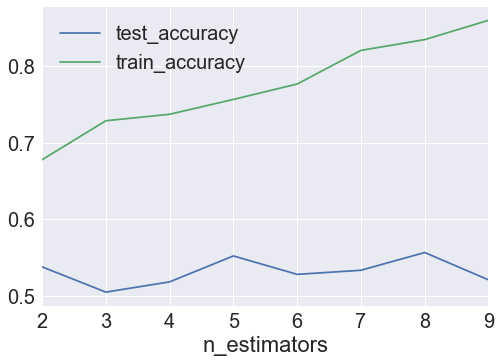

In [73]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost(data, estimator, nEstimators=1):

    model = AdaBoostClassifier(base_estimator = estimator, n_estimators = nEstimators)
    model.fit(X_train, y_train)
   
    ## Making predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    return train_accuracy, test_accuracy   

n_estimators = []
maxN=0
maxTestAcc = 0
train_acc = []
test_acc = []

# checking how accuracy depends on the number of estimators 

for i in range (2,10):
#    train_accuracy, test_accuracy = adaboost(data,SVC(kernel='rbf',gamma=0.4,probability=True), i)
    train_accuracy, test_accuracy = adaboost(data,DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=5,max_features = 15), i)
    n_estimators.append(i)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    if(test_accuracy>maxTestAcc):
        maxTestAcc=test_accuracy
        maxN=i

df = pd.DataFrame({'n_estimators':n_estimators,'train_accuracy':train_acc,'test_accuracy':test_acc})
df = df.set_index('n_estimators')

print('The best test accuracy is', round(maxTestAcc,3))
print('number of estimators:', round(maxN,3))

print(df)
df.plot()    

In [65]:
from sklearn.ensemble import AdaBoostClassifier
# applying decision trees as a weak learner

AdaBoostModel = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=5,max_features = 15), n_estimators = 8)

fit_redict_print(AdaBoostModel)  

Training accuracy: 0.85
Test accuracy: 0.545
R2 score: -0.819
Classification Report: 
              precision    recall  f1-score   support

         -1       0.55      0.58      0.57       573
          1       0.54      0.51      0.52       551

avg / total       0.55      0.55      0.54      1124



## Applying XGBoost

Gradient boosting is a machine learning technique which iteratively produces a prediction model using an ensemble of weak “learners” (usually, decision trees). At each iteration, the algorithm attempts to find areas of misclassification and then “boost” the importance of those incorrectly predicted data points. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=49, silent=True,
       subsample=1)


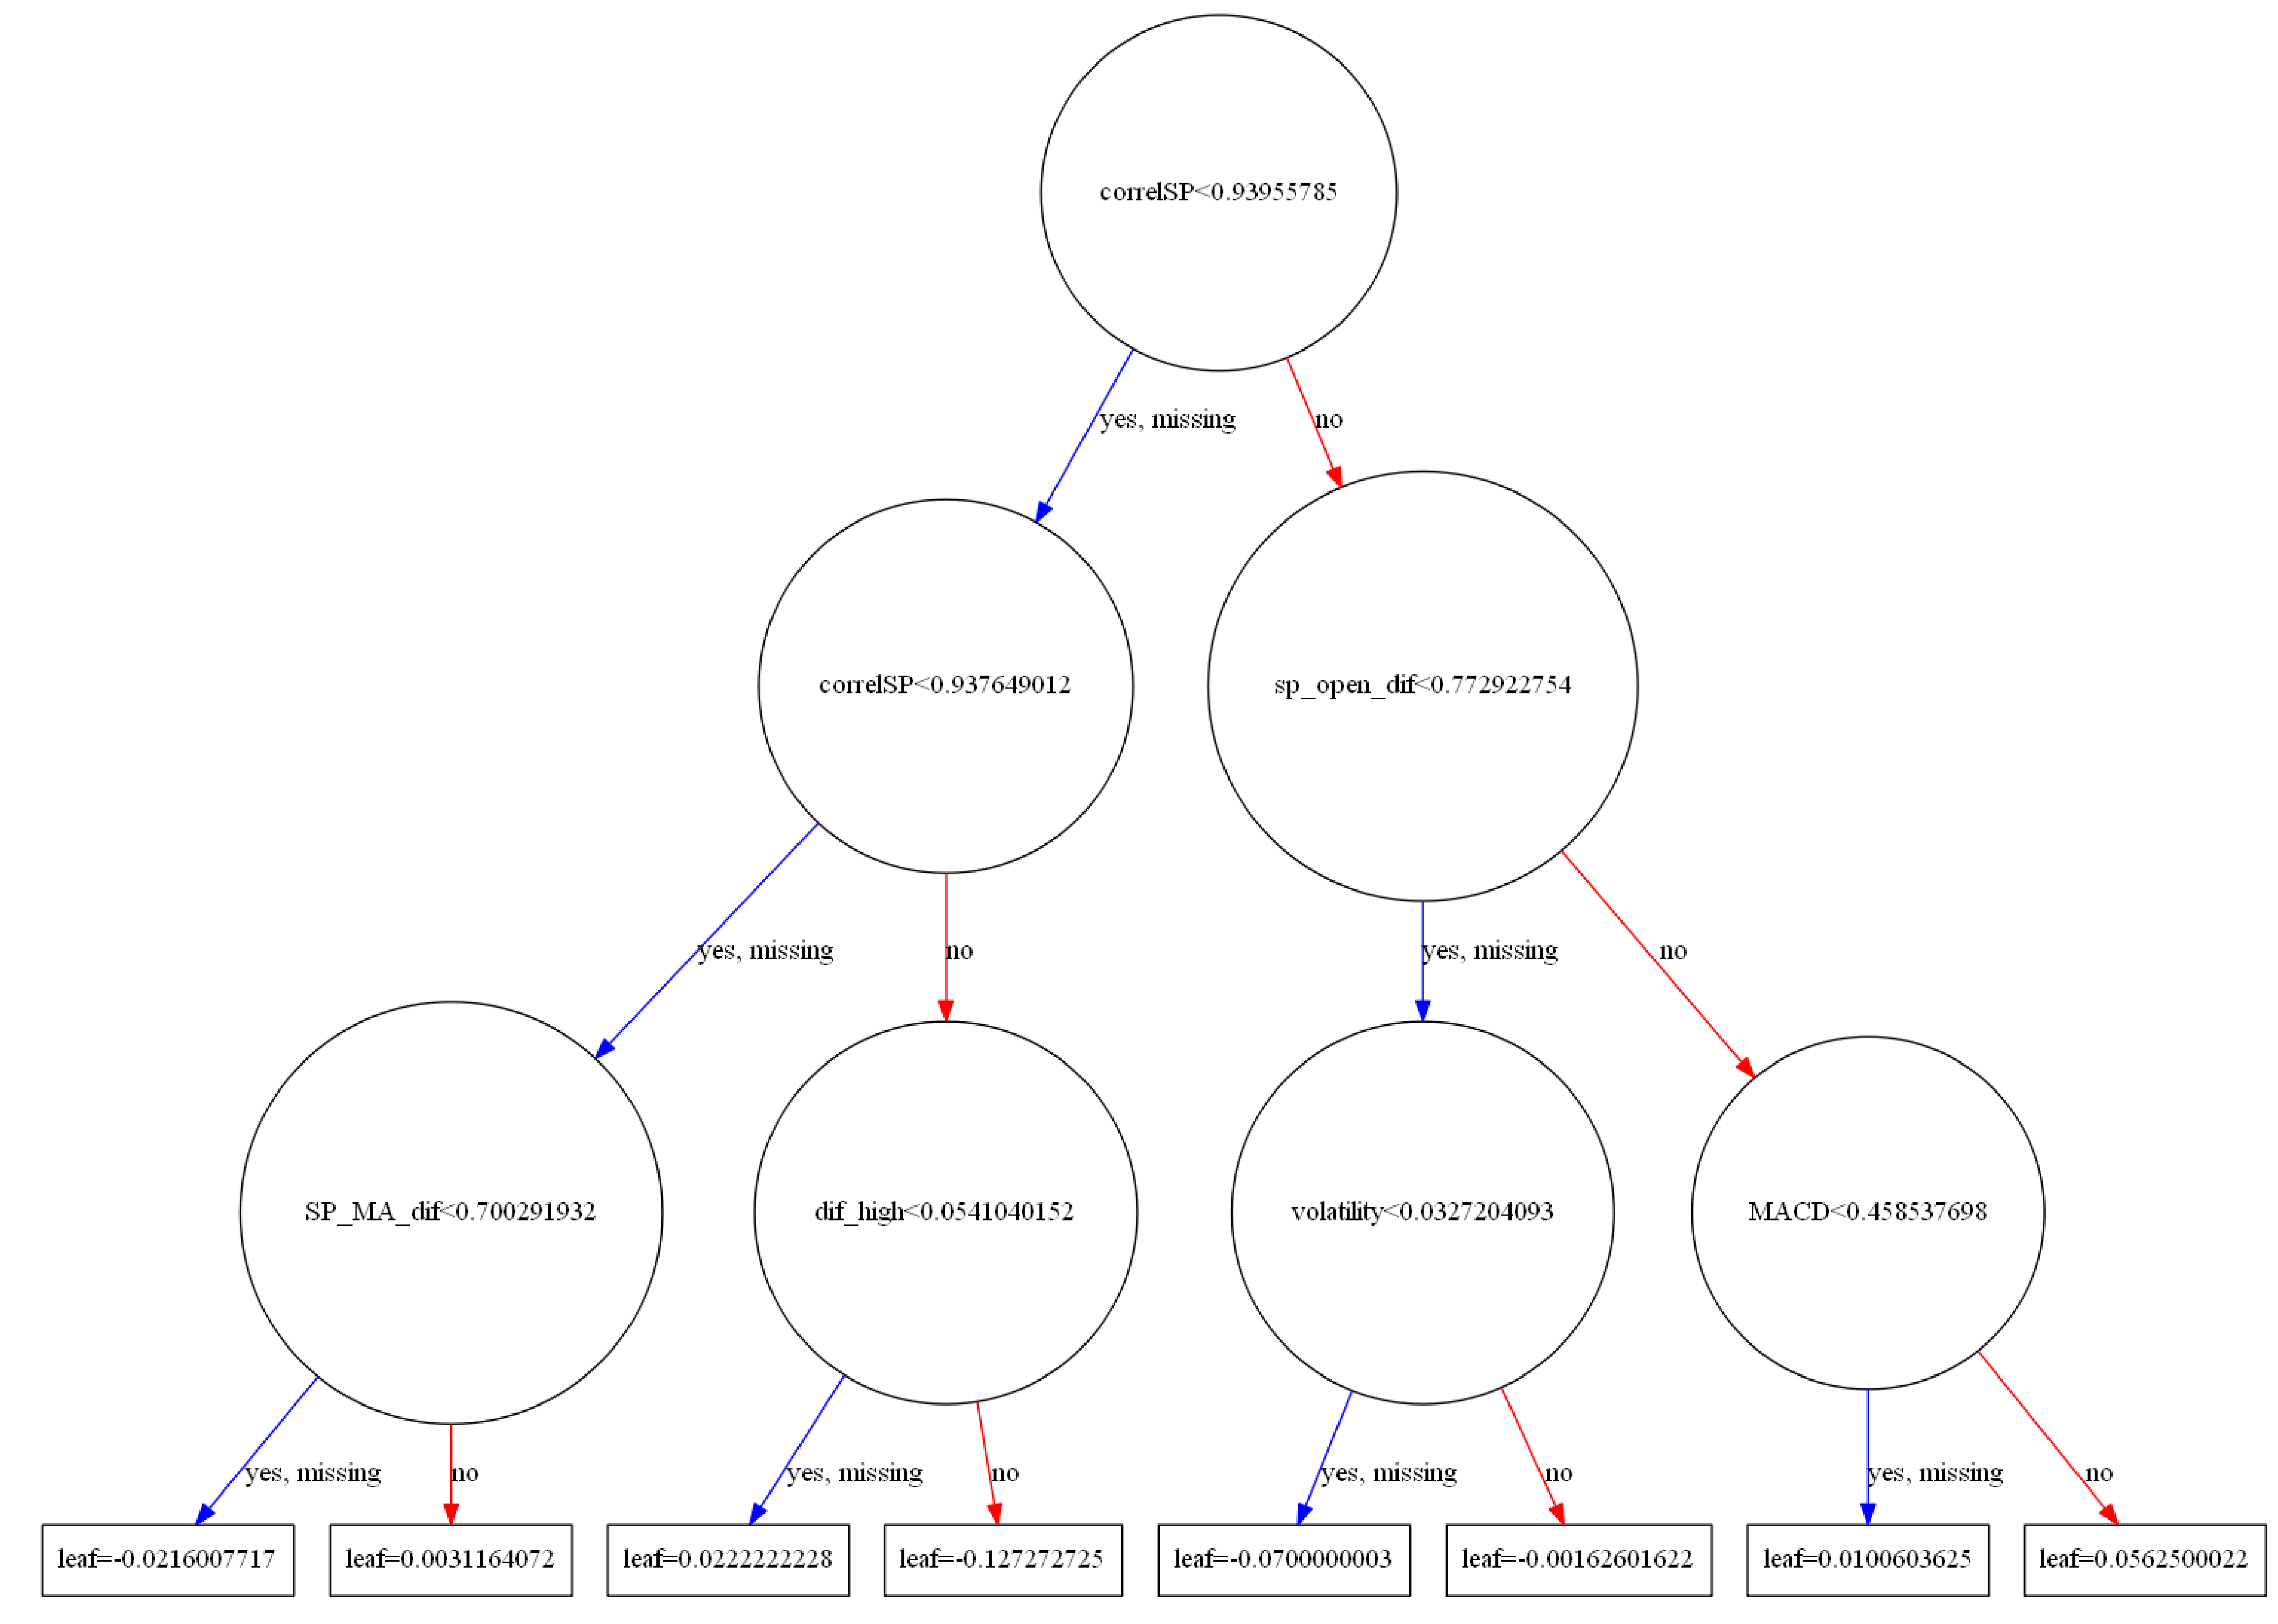

Training accuracy: 0.706
Test accuracy: 0.532
R2 score: -0.873
Classification Report: 
              precision    recall  f1-score   support

         -1       0.53      0.69      0.60       573
          1       0.53      0.36      0.43       551

avg / total       0.53      0.53      0.52      1124



C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [67]:
import os
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt


model = XGBClassifier(seed = 49)
model.fit(X_train, y_train)

print(model)

# plot a tree
rcParams['figure.figsize'] = 80,50

plot_tree(model) 
plt.show()

fit_redict_print(model)

## Tuning the model

In [49]:
# Tune objective
param_set0 = {
    'objective': ('reg:linear', 'binary:logistic','count:poisson')
}

xgb0 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=123)

gsearch0 = GridSearchCV(estimator=xgb0, param_grid=param_set0, scoring='roc_auc', n_jobs=4, cv=5) 
gsearch0.fit(X_train, y_train)

gs=gsearch0
print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)  


Grid scores:  [mean: 0.54264, std: 0.01461, params: {'objective': 'reg:linear'}, mean: 0.54432, std: 0.01517, params: {'objective': 'binary:logistic'}, mean: 0.54375, std: 0.01233, params: {'objective': 'count:poisson'}]
Best params:  {'objective': 'binary:logistic'}
Best score:  0.5443160578948116


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [50]:
# Tune max_depth and min_child_weight

param_test1 = {
    'max_depth': [10,20,30,40,50,60],
    'min_child_weight': [2,3,4,5,6,7]
}

xgb1 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='binary:logistic')
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring = 'roc_auc', n_jobs = 4, 
                        iid = False, cv = 5)
gsearch1.fit(X_train,y_train)

gs=gsearch1

print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)  

Best params:  {'max_depth': 30, 'min_child_weight': 2}
Best score:  0.5895301019752797


In [51]:
# Tune gamma
param_test2 = {
    'gamma':[i/10.0 for i in range(1,10,1)]
}

xgb2 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='binary:logistic', 
                     max_depth=30, min_child_weight=2)
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring = 'roc_auc',n_jobs = 4,
                         iid = False, cv = 5)
gsearch2.fit(X_train,y_train)

gs=gsearch2
print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)  

Grid scores:  [mean: 0.59148, std: 0.01267, params: {'gamma': 0.1}, mean: 0.59902, std: 0.01507, params: {'gamma': 0.2}, mean: 0.58437, std: 0.01475, params: {'gamma': 0.3}, mean: 0.58513, std: 0.00924, params: {'gamma': 0.4}, mean: 0.58814, std: 0.01661, params: {'gamma': 0.5}, mean: 0.58354, std: 0.01301, params: {'gamma': 0.6}, mean: 0.58298, std: 0.01731, params: {'gamma': 0.7}, mean: 0.58842, std: 0.01158, params: {'gamma': 0.8}, mean: 0.58134, std: 0.01317, params: {'gamma': 0.9}]
Best params:  {'gamma': 0.2}
Best score:  0.5990238337334027


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [52]:
# Tune reg_alpha and reg_lambda
param_test3 = {
    'reg_alpha': (0,2,4),
    'reg_lambda': (1,3,5)
}

xgb3 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='binary:logistic', 
                     max_depth=30, min_child_weight=2, gamma=0.2)
gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring = 'roc_auc',n_jobs = 4,
                         iid = False, cv = 5)
gsearch3.fit(X_train,y_train)

gs=gsearch3
print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)  

Grid scores:  [mean: 0.59902, std: 0.01507, params: {'reg_alpha': 0, 'reg_lambda': 1}, mean: 0.58500, std: 0.00992, params: {'reg_alpha': 0, 'reg_lambda': 3}, mean: 0.57700, std: 0.01246, params: {'reg_alpha': 0, 'reg_lambda': 5}, mean: 0.58360, std: 0.01245, params: {'reg_alpha': 2, 'reg_lambda': 1}, mean: 0.57528, std: 0.01344, params: {'reg_alpha': 2, 'reg_lambda': 3}, mean: 0.57539, std: 0.00851, params: {'reg_alpha': 2, 'reg_lambda': 5}, mean: 0.56896, std: 0.01774, params: {'reg_alpha': 4, 'reg_lambda': 1}, mean: 0.57377, std: 0.01635, params: {'reg_alpha': 4, 'reg_lambda': 3}, mean: 0.57163, std: 0.01193, params: {'reg_alpha': 4, 'reg_lambda': 5}]
Best params:  {'reg_alpha': 0, 'reg_lambda': 1}
Best score:  0.5990238337334027


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [53]:
# Tune subsample, colsample_bytree and colsample_bylevel
param_test4 = {
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'colsample_bylevel': (0.5, 1)
}

xgb4 = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='binary:logistic', 
                     max_depth=30, min_child_weight=2, gamma=0.2, reg_alpha=0, reg_lambda=1)
gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_test4, scoring = 'roc_auc',n_jobs = 4,
                         iid = False, cv = 5)
gsearch4.fit(X_train,y_train)

gs=gsearch4
print('Grid scores: ',gs.grid_scores_)
print('Best params: ',gs.best_params_)
print('Best score: ',gs.best_score_)  

Grid scores:  [mean: 0.57556, std: 0.01002, params: {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'subsample': 0.5}, mean: 0.59552, std: 0.01798, params: {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'subsample': 1}, mean: 0.56810, std: 0.00809, params: {'colsample_bylevel': 0.5, 'colsample_bytree': 1, 'subsample': 0.5}, mean: 0.58690, std: 0.01660, params: {'colsample_bylevel': 0.5, 'colsample_bytree': 1, 'subsample': 1}, mean: 0.57287, std: 0.01381, params: {'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'subsample': 0.5}, mean: 0.58396, std: 0.02035, params: {'colsample_bylevel': 1, 'colsample_bytree': 0.5, 'subsample': 1}, mean: 0.57261, std: 0.01460, params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'subsample': 0.5}, mean: 0.59902, std: 0.01507, params: {'colsample_bylevel': 1, 'colsample_bytree': 1, 'subsample': 1}]
Best params:  {'colsample_bylevel': 1, 'colsample_bytree': 1, 'subsample': 1}
Best score:  0.5990238337334027


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [66]:
# Select best model
# Make predictions on validation dataset using tuned parameters

tuned_model = XGBClassifier(silent=True, nthread=-1, max_delta_step=0.7, seed=0, objective='binary:logistic', 
                     max_depth=30, min_child_weight=2, gamma=0.2, reg_alpha=0, reg_lambda=1, subsample=1, 
                            colsample_bytree=1, colsample_bylevel=1)
tuned_fit = tuned_model.fit(X_train, y_train)
tuned_pred = tuned_model.predict(X_test)


fit_redict_print(tuned_model)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training accuracy: 1.0
Test accuracy: 0.565
R2 score: -0.741
Classification Report: 
              precision    recall  f1-score   support

         -1       0.57      0.61      0.59       573
          1       0.56      0.52      0.54       551

avg / total       0.56      0.56      0.56      1124



C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


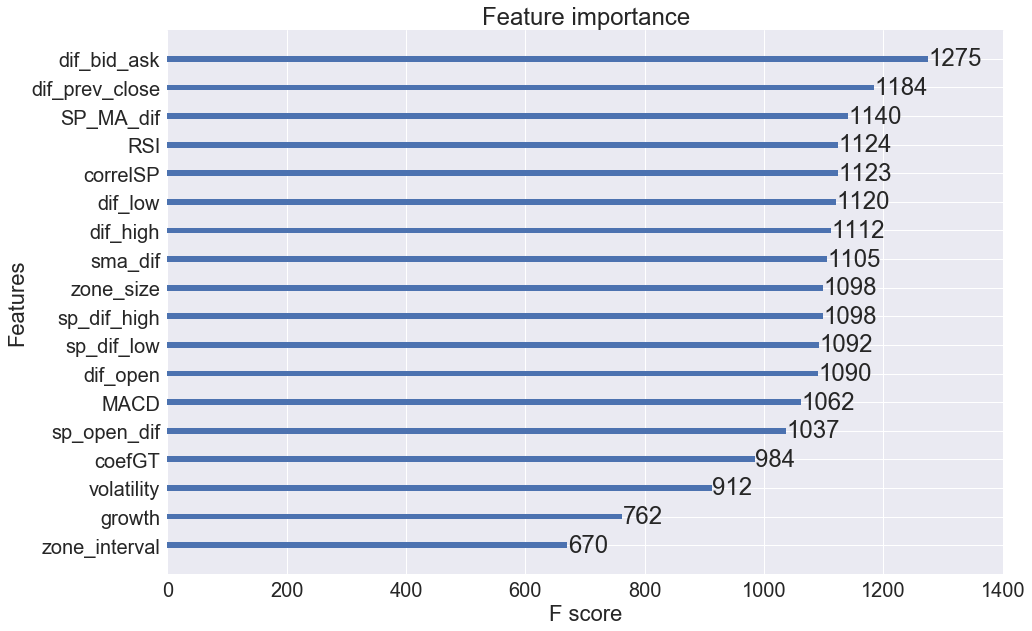

In [69]:
%matplotlib inline
import xgboost as xgb
import seaborn as sns
sns.set(font_scale = 2.0)
ax = xgb.plot_importance(tuned_model)
fig = ax.figure
fig.set_size_inches(15,10)
plt.savefig('../feat_imp.png')


## Comparing the models

In [56]:
from sklearn import model_selection
scoring = 'accuracy'

models = []
models.append(('1. KNN', KNNModel))
models.append(('2. DecTree', DecTreeModel))
models.append(('3. SVM_poly', SVM_poly_Model))
models.append(('4. SVM_RBF', SVM_RBF_Model))
models.append(('5. AdaBoost', AdaBoostModel))
models.append(('6. XGBoost', tuned_model))

results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = 49)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                cv = kfold, 
                                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1. KNN: 0.513134 (0.020712)
2. DecTree: 0.520701 (0.017376)
3. SVM_poly: 0.518252 (0.018051)
4. SVM_RBF: 0.519810 (0.010478)
5. AdaBoost: 0.528505 (0.027944)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

6. XGBoost: 0.558328 (0.023850)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


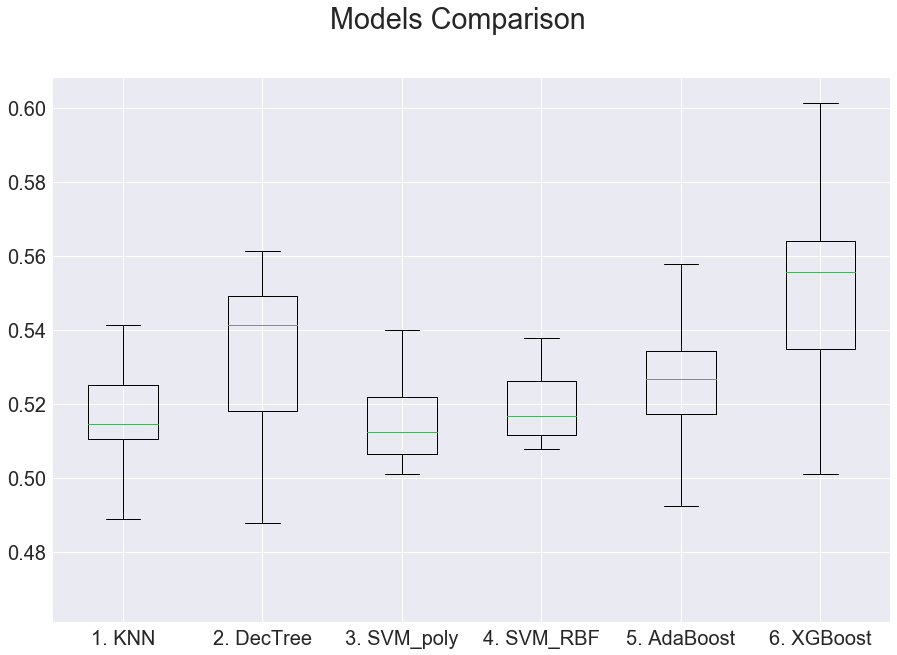

In [48]:

# Plot the comparison chart
fig = plt.figure()
fig.suptitle('Models Comparison')
fig.set_size_inches(15,10)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()